In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import pandas as pd
from keras import metrics
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from tqdm.keras import TqdmCallback 

# Load the Data

In [2]:
X_train = pd.read_csv('data/X_train.csv')
Y_train =  pd.read_csv('data/Y_train.csv')
X_val = pd.read_csv('data/X_val.csv')
Y_val = pd.read_csv('data/Y_val.csv')

X_train.drop(columns=['Unnamed: 0'], inplace=True)
Y_train.drop(columns=['Unnamed: 0'], inplace=True)
X_val.drop(columns=['Unnamed: 0'], inplace=True)
Y_val.drop(columns=['Unnamed: 0'], inplace=True)


# original_indexes = X_val.index.tolist()
# original_names = X_val['name_normalized'].tolist()
# original_positions = X_val['position'].tolist()
# original_teams =  X_val['player_team_name'].tolist()


X_train['player_id'] = pd.factorize(X_train['name_normalized'])[0]
X_val['player_id'] = pd.factorize(X_val['name_normalized'])[0]
Y_train['player_id'] = pd.factorize(Y_train['name_normalized'])[0]
Y_val['player_id'] = pd.factorize(Y_val['name_normalized'])[0]

X_train.drop('name_normalized', axis=1, inplace=True)
X_val.drop('name_normalized', axis=1, inplace=True)
Y_train.drop('name_normalized', axis=1, inplace=True)
Y_val.drop('name_normalized', axis=1, inplace=True)

# Test Data

X_test = pd.read_csv('data/X_test.csv')
y_test = pd.read_csv('data/Y_test.csv')

X_test.drop(columns=['Unnamed: 0'], inplace=True)
y_test.drop(columns=['Unnamed: 0'], inplace=True)

X_test['player_id'] = pd.factorize(X_test['name_normalized'])[0]
y_test['player_id'] = pd.factorize(y_test['name_normalized'])[0]
X_test.drop('name_normalized', axis=1, inplace=True)
y_test.drop('name_normalized', axis=1, inplace=True)

# Need this for post mortem later
original_mapping_test = X_test[['player_id', 'player_team_name', 'position']].copy()


In [3]:
X_train.head()

,season,player_team_name,opp_team_name,opp_diff_ind,position,GW,was_home,assists_lag_1,bonus_lag_1,bps_lag_1,...,red_cards_lag_5,saves_lag_5,selected_lag_5,player_team_score_lag_5,opp_team_score_lag_5,threat_lag_5,total_points_lag_5,value_lag_5,yellow_cards_lag_5,player_id
0,2018-19,West Ham,Liverpool,4,DEF,1,False,-0.184964,-0.215403,-0.606985,...,-0.093734,-0.177503,-0.409936,-1.808301,-1.899736,-0.529878,-0.752585,-3.373454,-0.430582,0
1,2018-19,West Ham,Bournemouth,1,DEF,2,True,-0.184964,-0.215403,-0.606985,...,-0.093734,-0.177503,-0.155985,-1.808301,3.816565,-0.529878,-0.752585,0.329490,-0.430582,0
2,2018-19,West Ham,Arsenal,4,DEF,3,False,-0.184964,-0.215403,-0.606985,...,-0.093734,-0.177503,-0.170799,-1.121215,2.387490,-0.529878,-0.752585,0.329490,-0.430582,0
3,2018-19,West Ham,Wolves,2,DEF,4,True,-0.184964,-0.215403,-0.606985,...,-0.093734,-0.177503,-0.193770,-0.892187,2.387490,-0.529878,-0.752585,0.307048,-0.430582,0
4,2018-19,West Ham,Everton,2,DEF,5,False,-0.184964,-0.215403,0.433488,...,-0.093734,-0.177503,-0.212392,-1.121215,1.672952,-0.529878,-0.611039,0.278995,1.677694,0


## Feature Engineering

In [4]:
def one_hot_encode_categorical(train_df, val_df, test_df, categorical_vars):
    """Creates one hot encodings for categorical cols and removes the original cols from the resulting datasets"""
    for var in categorical_vars:
        # Fit the encoder on the training set
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        train_column = train_df[[var]]

        # Fit and transform training set
        encoded_train = encoder.fit_transform(train_column)
        encoded_train_df = pd.DataFrame(encoded_train, columns=[f'{var}_{cat}' for cat in encoder.get_feature_names_out([var])])
        train_df = pd.concat([train_df, encoded_train_df], axis=1)

        # Transform validation set, handle unknown categories
        val_column = val_df[[var]]
        encoded_val = encoder.transform(val_column)
        encoded_val_df = pd.DataFrame(encoded_val, columns=[f'{var}_{cat}' for cat in encoder.get_feature_names_out([var])])
        val_df = pd.concat([val_df, encoded_val_df], axis=1)

        # Transform test set, handle unknown categories
        test_column = test_df[[var]]
        encoded_test = encoder.transform(test_column)
        encoded_test_df = pd.DataFrame(encoded_test, columns=[f'{var}_{cat}' for cat in encoder.get_feature_names_out([var])])
        test_df = pd.concat([test_df, encoded_test_df], axis=1)

        # Drop the original column in both sets
    
        train_df = train_df.drop([var], axis=1)
        val_df = val_df.drop([var], axis=1)
        test_df = test_df.drop([var], axis=1)
        

    return train_df, val_df, test_df




# Example function to create sequences and align targets
def create_sequences_and_targets(X, Y, sequence_length):
    """Returns a tensorys x, y and a df with cols: player_id, index"""
    sequences = []
    targets = []
    player_mapping = {'player_id': [], 'tensor_index': []}

    for player_id, group in X.groupby('player_id'):
        player_targets = Y[Y['player_id'] == player_id]['total_points']

        for start_idx in range(len(group) - sequence_length + 1):
            end_idx = start_idx + sequence_length
            sequences.append(group.iloc[start_idx:end_idx].values)
            targets.append(player_targets.iloc[end_idx - 1])  # Aligning target
            player_mapping['player_id'].append(player_id)
            player_mapping['tensor_index'].append(len(targets) - 1)

    return np.array(sequences), np.array(targets), pd.DataFrame(player_mapping)



In [5]:
NONE_SEQ_CAT_VARS = ['player_team_name', 'opp_team_name', 'opp_diff_ind', 'position', 'GW', 'was_home']

# Run for train, val
X_train, X_val, X_test = one_hot_encode_categorical(X_train, X_val, X_test, NONE_SEQ_CAT_VARS)


In [6]:
cats_prefix = ('player_team_name', 'opp_team_name', 'opp_diff_ind', 'position', 'GW', 'was_home', 'season')


lag_1 = ['assists_lag_1', 'bonus_lag_1', 'bps_lag_1', 'clean_sheets_lag_1',
       'creativity_lag_1', 'goals_conceded_lag_1', 'goals_scored_lag_1',
       'ict_index_lag_1', 'influence_lag_1', 'minutes_lag_1',
       'own_goals_lag_1', 'penalties_missed_lag_1', 'penalties_saved_lag_1',
       'red_cards_lag_1', 'saves_lag_1', 'selected_lag_1',
       'player_team_score_lag_1', 'opp_team_score_lag_1', 'threat_lag_1',
       'total_points_lag_1', 'value_lag_1', 'yellow_cards_lag_1']

lag_3 = ['assists_lag_3', 'bonus_lag_3', 'bps_lag_3', 'clean_sheets_lag_3',
       'creativity_lag_3', 'goals_conceded_lag_3', 'goals_scored_lag_3',
       'ict_index_lag_3', 'influence_lag_3', 'minutes_lag_3',
       'own_goals_lag_3', 'penalties_missed_lag_3', 'penalties_saved_lag_3',
       'red_cards_lag_3', 'saves_lag_3', 'selected_lag_3',
       'player_team_score_lag_3', 'opp_team_score_lag_3', 'threat_lag_3',
       'total_points_lag_3', 'value_lag_3', 'yellow_cards_lag_3']

lag_5 = ['assists_lag_5', 'bonus_lag_5', 'bps_lag_5', 'clean_sheets_lag_5',
       'creativity_lag_5', 'goals_conceded_lag_5', 'goals_scored_lag_5',
       'ict_index_lag_5', 'influence_lag_5', 'minutes_lag_5',
       'own_goals_lag_5', 'penalties_missed_lag_5', 'penalties_saved_lag_5',
       'red_cards_lag_5', 'saves_lag_5', 'selected_lag_5',
       'player_team_score_lag_5', 'opp_team_score_lag_5', 'threat_lag_5',
       'total_points_lag_5', 'value_lag_5', 'yellow_cards_lag_5']

In [7]:
cont_settings = {
    'all': [lag_1, lag_3, lag_5],
    'one': [lag_1],
    'three': [lag_3],
    'five': [lag_5],
}
cat_settings = {
    'nil': [],
    'all': ['player_team_name', 'opp_team_name', 'opp_diff_ind', 'position', 'GW', 'was_home'],
    'basic': ['was_home', 'position'],
    'base_team': ['was_home', 'position', 'player_team_name'],
    'base_team_opp': ['was_home', 'position', 'player_team_name', 'opp_team_name'],
    'base_team_diff': ['was_home', 'position', 'player_team_name', 'opp_diff_ind'],
    'base_team_opp_diff': ['was_home', 'position', 'player_team_name', 'opp_team_name', 'opp_diff_ind'],
}

# Pre and Post Model Pipeline

In [8]:
def col_and_seq_pipeline(x_train, y_train, x_val, y_val, x_test, y_test, cat, cont, seq_len):
    """Selects the subset of features to use and creates time steps out of the resulting data set
    as well as a mapping for post mortem
    """
    def select_columns(df, categorical_prefixes, continuous_sets):
    # Select categorical columns based on prefixes
        categorical_cols = [col for col in df.columns if any(col.startswith(prefix) for prefix in categorical_prefixes)]
        
        # Select continuous columns based on specified sets
        continuous_cols = ['player_id']
        for continuous_set in continuous_sets:
            continuous_cols.extend(continuous_set)
        
    
        # Combine selected categorical and continuous columns
        selected_cols = categorical_cols + continuous_cols
        return df[selected_cols]
    train_feat_reduced = select_columns(x_train, cat, cont)
    val_feat_reduced = select_columns(x_val, cat, cont)
    test_feat_reduced = select_columns(x_test, cat, cont)
    x_t, y_t, _ = create_sequences_and_targets(train_feat_reduced, y_train, seq_len)
    x_v, y_v, _ = create_sequences_and_targets(val_feat_reduced, y_val, seq_len)
    x_test, y_test, mapping = create_sequences_and_targets(val_feat_reduced, y_val, seq_len)
    return x_t, y_t, x_v, y_v, x_test, y_test, mapping

In [9]:
def plot_history(history):
    """Plotting function for our Model"""
    hist = history.history
    x_arr = np.arange(len(hist['loss'])) + 1
    
    # Define custom colors for better visualization
    colors = {
        'train_loss': '#1f77b4',
        'val_loss': '#ff7f0e',
        'train_mse': '#FFA500',
        'val_mse': '#d62728',
        'train_mae': '#9467bd',
        'val_mae': '#8c564b'
    }
    
    # Create a figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
    
    # Plot Training and Validation Loss
    ax1.plot(x_arr, hist['loss'], '-o', color=colors['train_loss'], label='Train Loss')
    ax1.plot(x_arr, hist['val_loss'], '--<', color=colors['val_loss'], label='Validation Loss')
    ax1.legend(fontsize=12)
    ax1.set_xlabel('Epoch', size=12)
    ax1.set_ylabel('Loss', size=12)
    ax1.set_title('Loss by Epoch', size=14)
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    
    # Plot Training and Validation MAE
    ax2.plot(x_arr, hist['mean_absolute_error'], '-o', color=colors['train_mae'], label='Train MAE')
    ax2.plot(x_arr, hist['val_mean_absolute_error'], '--<', color=colors['val_mae'], label='Validation MAE')
    ax2.legend(fontsize=12)
    ax2.set_xlabel('Epoch', size=12)
    ax2.set_ylabel('MAE', size=12)
    ax2.set_title('MAE by Epoch', size=14)
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()
    pass

In [10]:
def compile_and_run_ls7(train_seq, y_train_seq, val_seq, y_val_seq, **kwargs):
    print("kwArgs: ", kwargs)
    sequence_length = train_seq.shape[1]
    num_features = train_seq.shape[2]
    lstm_size = kwargs.get('lstm_size', 50)
    epochs = kwargs.get('epochs', 2)    
    
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)
    dropout_rate = kwargs.get('dropout_rate', 0.5)

    model = Sequential([
        LSTM(lstm_size, return_sequences=True, input_shape=(sequence_length, num_features), name='LSTM1'),
        Dropout(dropout_rate, name='drop1'),
        LSTM(lstm_size, return_sequences=True, name='LSTM2'),
        Dropout(dropout_rate, name='drop2'),
        LSTM(lstm_size, return_sequences=True, name='LSTM3'),
        Dropout(dropout_rate, name='drop3'),
        LSTM(lstm_size, return_sequences=True, name='LSTM4'),
        Dropout(dropout_rate, name='drop4'),
        LSTM(lstm_size, return_sequences=True, name='LSTM5'),
        Dropout(dropout_rate, name='drop5'),
        LSTM(lstm_size, return_sequences=True, name='LSTM6'),
        Dropout(dropout_rate, name='drop6'),
        LSTM(lstm_size, return_sequences=False, name='LSTM7'),
        Dropout(dropout_rate, name='drop7'),
        Dense(units=1, activation='linear', name='Dense1')
    ])
    lr = kwargs.get("learning_rate", 0.001)
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse', 'mae'])
    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=[metrics.mse,
                 metrics.RootMeanSquaredError(),
                 metrics.mae]
        )

    # print(f"Training model with learning rate: {lr}")
    history = model.fit(train_seq, y_train_seq, epochs=epochs, batch_size=kwargs.get('batch_size',32), 
                        validation_data=(val_seq, y_val_seq), verbose=0,
                       callbacks=[TqdmCallback()])

    return model, history

# FINAL MODEL

In [11]:
train_seq, y_train_seq, val_seq, y_val_seq, x_test, y_test, seq_mapping = col_and_seq_pipeline(
    X_train, Y_train, X_val, Y_val, X_test, y_test, cat_settings.get('all'), cont_settings.get('all'), 7
)

model, history = compile_and_run_ls7(
    train_seq, y_train_seq, val_seq, y_val_seq, 
    seq_length=7, lstm_size=200, 
    cat_key='all', con_key='all', 
    learning_rate=0.001, dropout_rate=0.3,
    batch_size=32,
    epochs=45
)

kwArgs:  {'seq_length': 7, 'lstm_size': 200, 'cat_key': 'all', 'con_key': 'all', 'learning_rate': 0.001, 'dropout_rate': 0.3, 'batch_size': 32, 'epochs': 45}


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

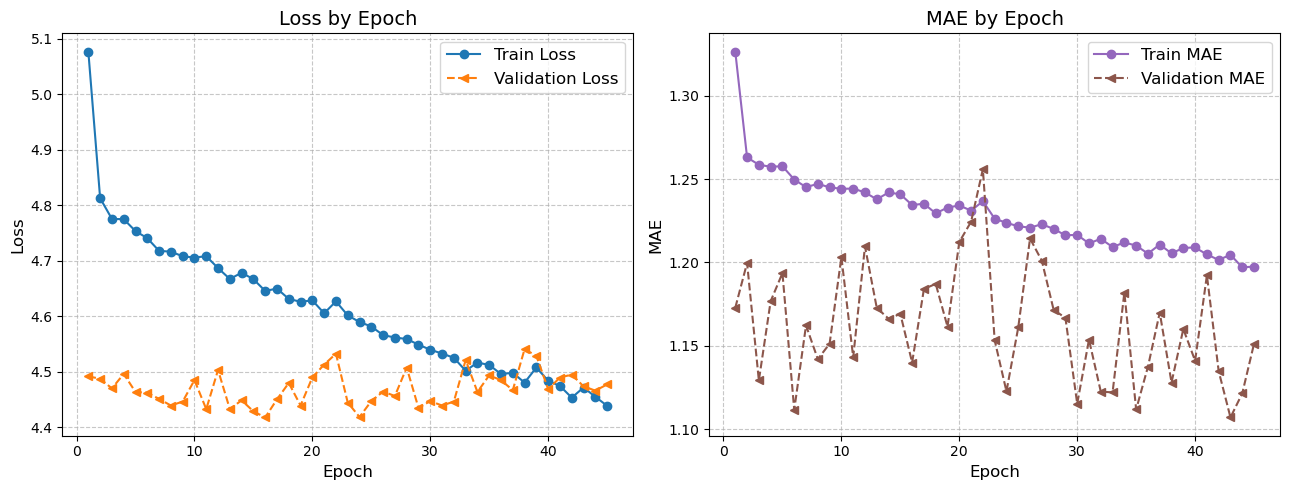

In [12]:
plot_history(history)

# Test Data Predictions

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred = model.predict(x_test, verbose=0)

# Calculate regression metrics

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print or use these metrics as needed
print("Test Statistics")
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R2): {r2}')

Test Statistics
Mean Squared Error (MSE): 4.477493506823405
Mean Absolute Error (MAE): 1.1514030551497187
R-squared (R2): 0.26009273266862687


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM1 (LSTM)                (None, 7, 200)            292800    
                                                                 
 drop1 (Dropout)             (None, 7, 200)            0         
                                                                 
 LSTM2 (LSTM)                (None, 7, 200)            320800    
                                                                 
 drop2 (Dropout)             (None, 7, 200)            0         
                                                                 
 LSTM3 (LSTM)                (None, 7, 200)            320800    
                                                                 
 drop3 (Dropout)             (None, 7, 200)            0         
                                                                 
 LSTM4 (LSTM)                (None, 7, 200)            3